# RAPIDS Hands-on Example Notebook Answers

This notebook provides a hands-on demonstration of an ETL and ML workflow using the RAPIDS ecosystem. We will be using the California Housing Prices dataset from Scikit-learn to create a model which will predict housing prices. We will also cluster and visualize the data.

We first load the California Housing Prices dataset into Pandas dataframes on the CPU

In [1]:
from sklearn.datasets import fetch_california_housing

dataset = fetch_california_housing(as_frame=True)

X_cpu = dataset['data']
y_cpu = dataset['target']

In [2]:
X_cpu

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [3]:
y_cpu

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

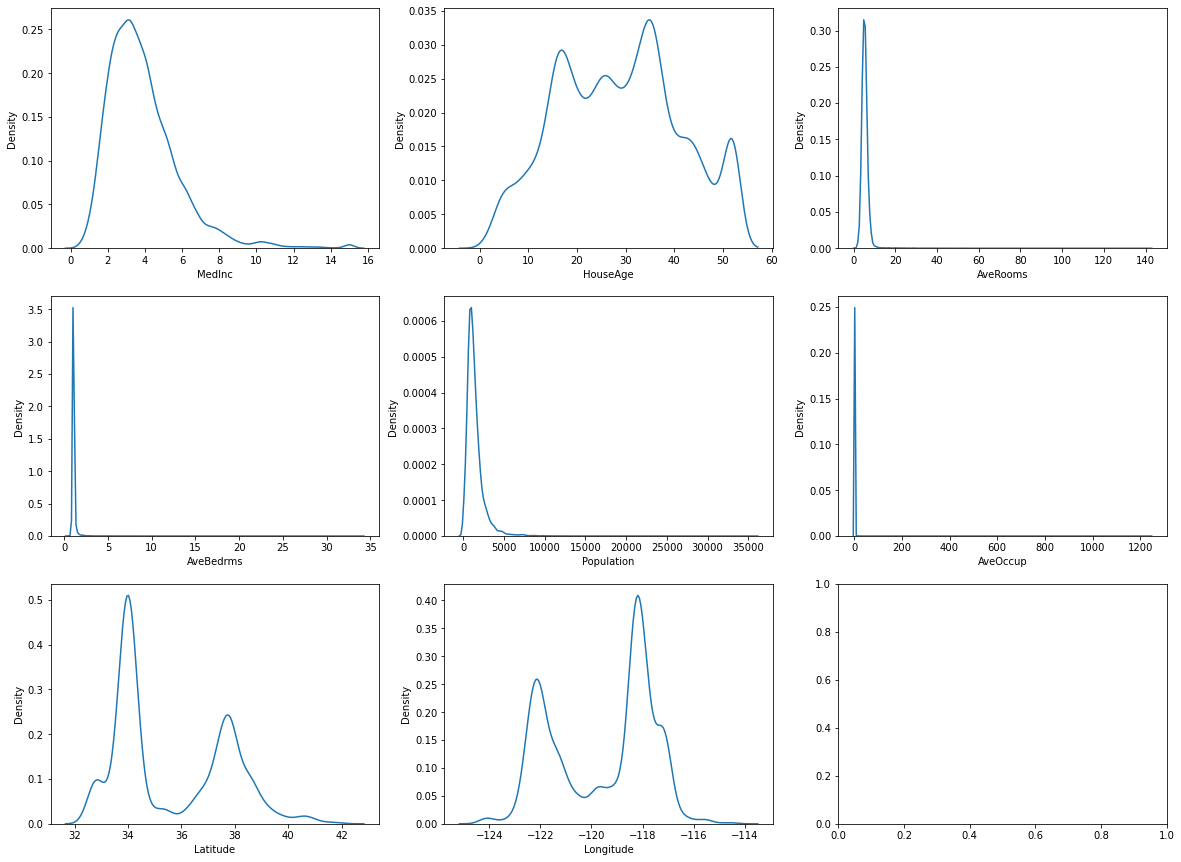

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,15))
for i, col in enumerate(X_cpu.columns):
    sns.kdeplot(X_cpu[col], ax=axes[i//3,i%3])

Next, we convert the Pandas dataframes into cuDF dataframes on the GPU. This is done using `cudf.Dataframe.from_pandas()` and `cudf.Series.from_pandas()`

In [4]:
import cudf

In [5]:
X = cudf.DataFrame.from_pandas(X_cpu)
y = cudf.Series.from_pandas(y_cpu)

Next, let's perform some filtering of the geo-coordinates. Let's filter X to include everything with Latitude between (36, 40) and Longitude between (-123, -120). Also make sure to filter `y` to keep only those fields which have been kept in `X`.

In [6]:
X = X.query('Latitude > 36 and Latitude < 40 and Longitude > -123 and Longitude < -120')
y = y[X.index]

Let's perform some light feature engineering by normalizing all the feature columns into z-scores

In [7]:
for col in X.columns:
    X[col] = ((X[col] - X[col].mean()) / X[col].std()).astype('float32')

In [8]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.282937,0.840348,0.432496,-0.124766,-0.927041,-0.029350,-0.061302,-0.665338
1,2.270447,-0.638101,0.194785,-0.209089,1.010284,-0.059683,-0.092320,-0.648488
2,1.722561,1.653495,0.848020,-0.044166,-0.764898,-0.012561,-0.107830,-0.682189
3,0.875385,1.653495,0.060701,-0.044794,-0.707123,-0.029868,-0.107830,-0.699039
4,-0.067618,1.653495,0.208715,-0.031768,-0.700600,-0.054808,-0.107830,-0.699039
...,...,...,...,...,...,...,...,...
20635,-1.267246,-0.342411,-0.185265,0.053080,-0.439681,-0.029006,2.420191,1.255575
20636,-0.744288,-0.859868,0.155239,0.349354,-0.895358,0.009253,2.435700,1.053374
20637,-1.193932,-0.933790,-0.134253,0.031579,-0.288721,-0.044997,2.342644,1.036524
20638,-1.106186,-0.859868,-0.094750,0.115737,-0.536594,-0.058773,2.342644,0.868023


In [9]:
import cuml 

In [10]:
pca = cuml.decomposition.PCA(n_components=X.shape[1])
reduced = pca.fit_transform(X)

In [11]:
pca.explained_variance_

0    2.053467
1    1.423740
2    1.358875
3    1.004003
4    0.865421
5    0.813841
6    0.438986
7    0.041667
dtype: float32

In [12]:
kmeans = cuml.cluster.KMeans(n_clusters=5)
clusters = kmeans.fit_predict(X)

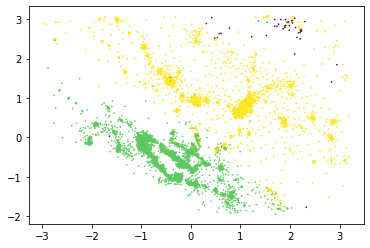

In [13]:
import matplotlib.pyplot as plt
plt.scatter(X['Latitude'].to_pandas(), X['Longitude'].to_pandas(), c=clusters.to_pandas(), s=0.4)

We no longer need the `Latitude` and `Longitude` columns, so let's drop them from the DataFrame

In [14]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.282937,0.840348,0.432496,-0.124766,-0.927041,-0.029350,-0.061302,-0.665338
1,2.270447,-0.638101,0.194785,-0.209089,1.010284,-0.059683,-0.092320,-0.648488
2,1.722561,1.653495,0.848020,-0.044166,-0.764898,-0.012561,-0.107830,-0.682189
3,0.875385,1.653495,0.060701,-0.044794,-0.707123,-0.029868,-0.107830,-0.699039
4,-0.067618,1.653495,0.208715,-0.031768,-0.700600,-0.054808,-0.107830,-0.699039
...,...,...,...,...,...,...,...,...
20635,-1.267246,-0.342411,-0.185265,0.053080,-0.439681,-0.029006,2.420191,1.255575
20636,-0.744288,-0.859868,0.155239,0.349354,-0.895358,0.009253,2.435700,1.053374
20637,-1.193932,-0.933790,-0.134253,0.031579,-0.288721,-0.044997,2.342644,1.036524
20638,-1.106186,-0.859868,-0.094750,0.115737,-0.536594,-0.058773,2.342644,0.868023


Let's start by using LASSO to get a rough idea of feature importance

In [15]:
lasso = cuml.linear_model.Lasso(alpha=0.001)
lasso.fit(X, y)

Lasso(alpha=0.001, fit_intercept=True, normalize=False, max_iter=1000, tol=0.001, selection='cyclic', handle=<cuml.raft.common.handle.Handle object at 0x7f3449f63510>, output_type='cudf', verbose=4)

In [16]:
feature_importance = lasso.coef_[lasso.coef_.abs().argsort()].abs().reverse()
feature_importance

0    0.723581
7    0.324211
6    0.236364
1    0.132531
3    0.127001
5    0.046285
2    0.042137
4    0.004984
dtype: float32

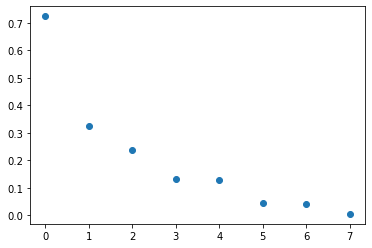

In [17]:
import numpy as np
plt.scatter(np.arange(8), feature_importance.to_pandas())

In [18]:
X.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [19]:
X.columns[feature_importance.index.values.get()]

Index(['MedInc', 'Longitude', 'Latitude', 'HouseAge', 'AveBedrms', 'AveOccup',
       'AveRooms', 'Population'],
      dtype='object')

We can see from above that Population has almost no predictive power so we can drop that from our dataset

Let's split our data into a training and testing sets

In [20]:
X_train, X_test, y_train, y_test = cuml.train_test_split(X, y)

Let's use Random Forests to predict the 

In [21]:
model = cuml.linear_model.ElasticNet()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

In [22]:
model.score(X_test, y_test)

0.22917338237861162

In [23]:
print("MSE: %s" % (y_test.reset_index(drop=True) - y_hat).abs().sum()**2)

MSE: 2298661.7035373044


In [24]:
rf = cuml.ensemble.RandomForestRegressor(max_depth=5, n_estimators=100)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)

In [25]:
print("MSE: %s" % (y_test.reset_index(drop=True) - y_hat).abs().sum()**2)

MSE: 665233.9842644216


In [26]:
rf.score(X_test, y_test)

0.7300010919570923

In [27]:
model = cuml.neighbors.KNeighborsRegressor(n_neighbors=15)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

In [28]:
print("MSE: %s" % (y_test.reset_index(drop=True) - y_hat).abs().sum())

MSE: 718.9144654201125


In [29]:
model.score(X_test, y_test)

0.7682122546697716

In [30]:
model = cuml.svm.SVR(kernel='rbf')
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

In [31]:
print("MSE: %s" % (y_test.reset_index(drop=True) - y_hat).abs().sum())

MSE: 683.2317506858063


In [32]:
model.score(X_test, y_test)

0.7698518798690545

Since it is has such a low feature importance, let's drop the 'Population' feature from X_train and X_test and see if it has a positive affect on our SVR model predictions. 

In [33]:
X_train = X_train.drop(columns="Population")
X_test = X_test.drop(columns="Population")

In [34]:
model = cuml.svm.SVR(kernel='rbf')
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

In [35]:
print("MSE: %s" % (y_test.reset_index(drop=True) - y_hat).abs().sum())

MSE: 676.2087480908966


In [36]:
model.score(X_test, y_test)

0.772380284507129